<a href="https://colab.research.google.com/github/michiWS1920/nfl_data/blob/michi/playingaround.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
library(tidyverse)
library(ggplot2)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [ ]:
install.packages("googledrive")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gargle’




In [ ]:
library(googledrive)

In [ ]:
chicken <- drive_upload(
  drive_example("chicken.csv"),
  "README-chicken.csv"

In [ ]:
first <- 2009 
last <- 2019 

datalist = list()
for (yr in first:last) {
    pbp <- read_csv(url(paste0("https://github.com/ryurko/nflscrapR-data/raw/master/play_by_play_data/regular_season/reg_pbp_", yr, ".csv"))) #read every play by play data
    games <- read_csv(url(paste0("https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/games_data/regular_season/reg_games_", yr, ".csv"))) #read game data including score/ week etc.
    pbp <- pbp %>% 
      inner_join(games %>% distinct(game_id, week, season)) %>% #join the two
      select(-fumble_recovery_2_yards, -blocked_player_id, -fumble_recovery_2_player_id) # throw some variables out that are inconsistent in format over the seasons
    datalist[[yr]] <- pbp 
}

pbp_all <- dplyr::bind_rows(datalist)

In [ ]:
# Change teamnames for teams that changed their names in the last 10 seasons - to have consistent data
pbp_all <- pbp_all %>% 
	mutate_at(vars(home_team, away_team, posteam, defteam), funs(case_when(
            . %in% "JAX" ~ "JAC",
            . %in% "STL" ~ "LA",
            . %in% "SD" ~ "LAC",
            TRUE ~ .
        ))) 

In [3]:
#saveRDS(pbp_all, file="NFLdata.rds")
pbp_all <- readRDS("NFLdata.rds")

In [4]:
# cleaning for further analysis
pbp_all_rp <- pbp_all %>%
      filter(!is.na(epa), !is.na(posteam), play_type=="no_play" | play_type=="pass" | play_type=="run") %>% #filter out certain NA values, only show three play_types
	mutate( #create new columns that indicates if the play was a pass or rush - this is done by parsing the description of the play (certain keywords are perfect indicators)
	pass = if_else(str_detect(desc, "( pass)|(sacked)|(scramble)"), 1, 0), #
	rush = if_else(str_detect(desc, "(left end)|(left tackle)|(left guard)|(up the middle)|(right guard)|(right tackle)|(right end)") & pass == 0, 1, 0),
	success = ifelse(epa>0, 1 , 0),
	passer_player_name = ifelse(play_type == "no_play" & pass == 1, #create new column that parses the player_name depending on the type of play (pass / receiver / rusher)
              str_extract(desc, "(?<=\\s)[A-Z][a-z]*\\.\\s?[A-Z][A-z]+(\\s(I{2,3})|(IV))?(?=\\s((pass)|(sack)|(scramble)))"),
              passer_player_name),
        receiver_player_name = ifelse(play_type == "no_play" & str_detect(desc, "pass"), 
              str_extract(desc, "(?<=to\\s)[A-Z][a-z]*\\.\\s?[A-Z][A-z]+(\\s(I{2,3})|(IV))?"),
              receiver_player_name),
        rusher_player_name = ifelse(play_type == "no_play" & rush == 1, 
              str_extract(desc, "(?<=\\s)[A-Z][a-z]*\\.\\s?[A-Z][A-z]+(\\s(I{2,3})|(IV))?(?=\\s((left end)|(left tackle)|(left guard)|		      (up the middle)|(right guard)|(right tackle)|(right end)))"),
              rusher_player_name),
	name = ifelse(!is.na(passer_player_name), passer_player_name, rusher_player_name),
	yards_gained=ifelse(play_type=="no_play",NA,yards_gained), # filter out NA for yards_gained
	play=1
	) 

In [ ]:
pbp_all_rp %>%
select(play_type) %>%
head()

play_type
<chr>
pass
run
pass
run
pass
run


Problem is Timeouts are in noplay, have to filter them out


In [ ]:
pbp_all_rp %>%
group_by(season) %>%
filter(play_type== "no_play", str_detect(desc, "(Timeout)")) %>%
select(desc)

Adding missing grouping variables: `season`



season,desc
<dbl>,<chr>
2009,Timeout #1 by PIT at 01:29.
2009,Timeout #1 by TEN at 00:54.
2009,Timeout #2 by PIT at 00:27.
2009,Timeout #3 by PIT at 00:07.
2009,Timeout #1 by PIT at 01:03.
2009,Timeout #2 by PIT at 00:44.
2009,Timeout #3 by PIT at 00:41.
2009,Timeout #1 by PIT at 10:34.
2009,Timeout #1 by CLE at 01:46.


In [ ]:
pbp_all_rp %>%
group_by(season) %>%
filter(penalty == 1, !str_detect(desc, "(Timeout)")) %>%
#select(desc) %>%
count(season) -> pbp_all_flags
pbp_all_flags

season,n
<dbl>,<int>
2009,2593
2010,2673
2011,2860
2012,2801
2013,2724
2014,2945
2015,3067
2016,3018
2017,2959


In [ ]:
pbp_all_rp %>%
group_by(season) %>%
filter(penalty == 1, !str_detect(desc, "(Timeout)"), str_detect(desc, "(Holding)")) %>%
select(desc) %>%
count(season)


Adding missing grouping variables: `season`



season,n
<dbl>,<int>
2009,495
2010,538
2011,568
2012,614
2013,587
2014,681
2015,765
2016,756
2017,740


NFL started to take holding much more seriously in later seasons. 

In [ ]:
pbp_all_rp %>%
group_by(season) %>%
filter(penalty == 1, !str_detect(desc, "(Timeout)"), str_detect(desc, "(Mask)")) %>%
select(desc) %>%
count(season)

Adding missing grouping variables: `season`



season,n
<dbl>,<int>
2009,86
2010,56
2011,90
2012,58
2013,74
2014,79
2015,83
2016,91
2017,84


In [ ]:
pbp_all_rp %>%
group_by(season) %>%
filter(penalty == 1, !str_detect(desc, "(Timeout)"), str_detect(desc, "(Roughing)")) %>%
select(desc) %>%
count(season)

Adding missing grouping variables: `season`



season,n
<dbl>,<int>
2009,67
2010,79
2011,102
2012,98
2013,93
2014,104
2015,102
2016,95
2017,106


* Roughing the passer has been more stronlgy enforced since 2019 per rule change

In [ ]:
names(pbp_all_rp)

ERROR: ignored

In [ ]:
pbp_all_rp %>%
group_by(season) %>%
filter(penalty == 1, !str_detect(desc, "(Timeout)")) %>%
select(desc, penalty_team) %>%
count(penalty_team) -> penalty_teams_per_season
penalty_teams_per_season

Adding missing grouping variables: `season`



season,penalty_team,n
<dbl>,<chr>,<int>
2009,ARI,91
2009,ATL,72
2009,BAL,96
2009,BUF,90
2009,CAR,74
2009,CHI,84
2009,CIN,101
2009,CLE,63
2009,DAL,102


In [5]:
pbp_all_rp <- pbp_all_rp %>% 
	mutate_at(vars(penalty_team), funs(case_when(
            . %in% "JAX" ~ "JAC",
            . %in% "STL" ~ "LA",
            . %in% "SD" ~ "LAC",
            TRUE ~ .
        ))) 

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



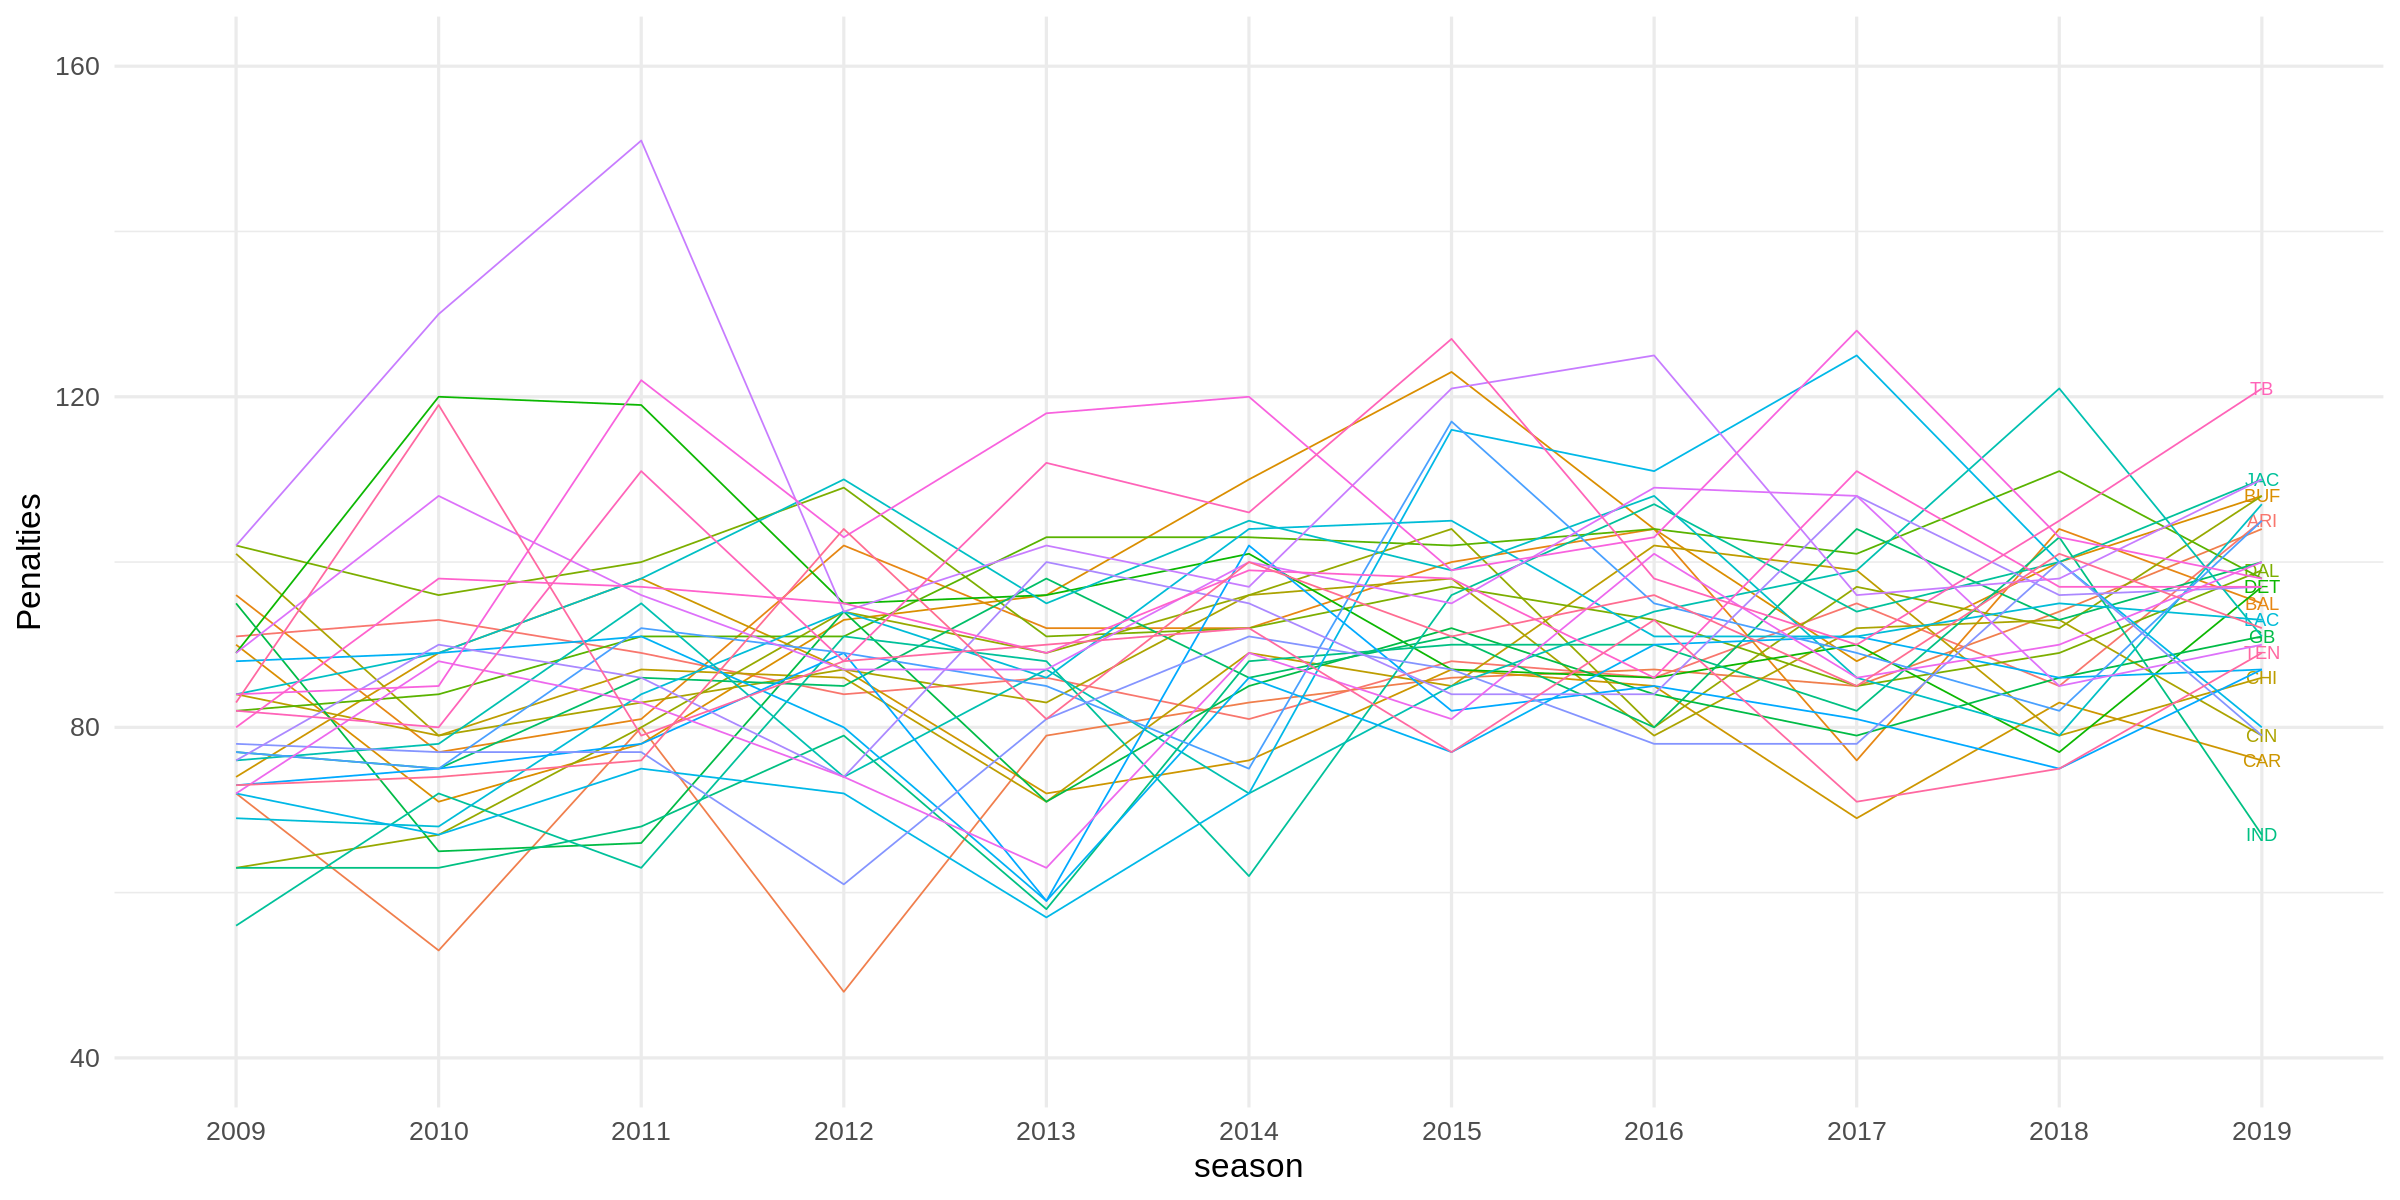

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)

penalty_teams_per_season %>%
group_by(penalty_team) %>%
ggplot(aes(x= season , y=n, color=penalty_team)) +
geom_text(data=penalty_teams_per_season %>% filter(season == 2019), aes(label=penalty_team), check_overlap = TRUE) +
geom_line() + 
xlim(2009, 2019) +
ylim(40, 160) +
labs(y = "Penalties") +
scale_x_discrete(limits= c(2009:2019))+
theme_minimal(base_size = 20) +
theme(legend.position = "none")

do same but with penalty_yards not just penalty_count

In [ ]:
pbp_all_rp %>%
select(desc, penalty, play_type)

* Rausgefunden, nicht jede FLAG führt dazu dass Play_Type = NO_PLAY - bessere Form des filterns ist penalty == 1

In [ ]:
pbp_all_rp %>%
group_by(season, penalty_team) %>%
filter(penalty == 1, !str_detect(desc, "(Timeout)")) %>%
select(desc, penalty_team, penalty_yards) %>%
summarize(Sum_Penalty_Yards = sum(penalty_yards)) -> penalty_teams_yards
penalty_teams_yards


Adding missing grouping variables: `season`

`summarise()` regrouping output by 'season' (override with `.groups` argument)



season,penalty_team,Sum_Penalty_Yards
<dbl>,<chr>,<dbl>
2009,ARI,765
2009,ATL,614
2009,BAL,928
2009,BUF,689
2009,CAR,578
2009,CHI,689
2009,CIN,728
2009,CLE,542
2009,DAL,788


In [ ]:
summary(penalty_teams_yards)

     season     penalty_team       Sum_Penalty_Yards
 Min.   :2009   Length:352         Min.   : 367.0   
 1st Qu.:2011   Class :character   1st Qu.: 680.0   
 Median :2014   Mode  :character   Median : 753.0   
 Mean   :2014                      Mean   : 754.7   
 3rd Qu.:2017                      3rd Qu.: 830.0   
 Max.   :2019                      Max.   :1262.0   
                                   NA's   :3        

Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”


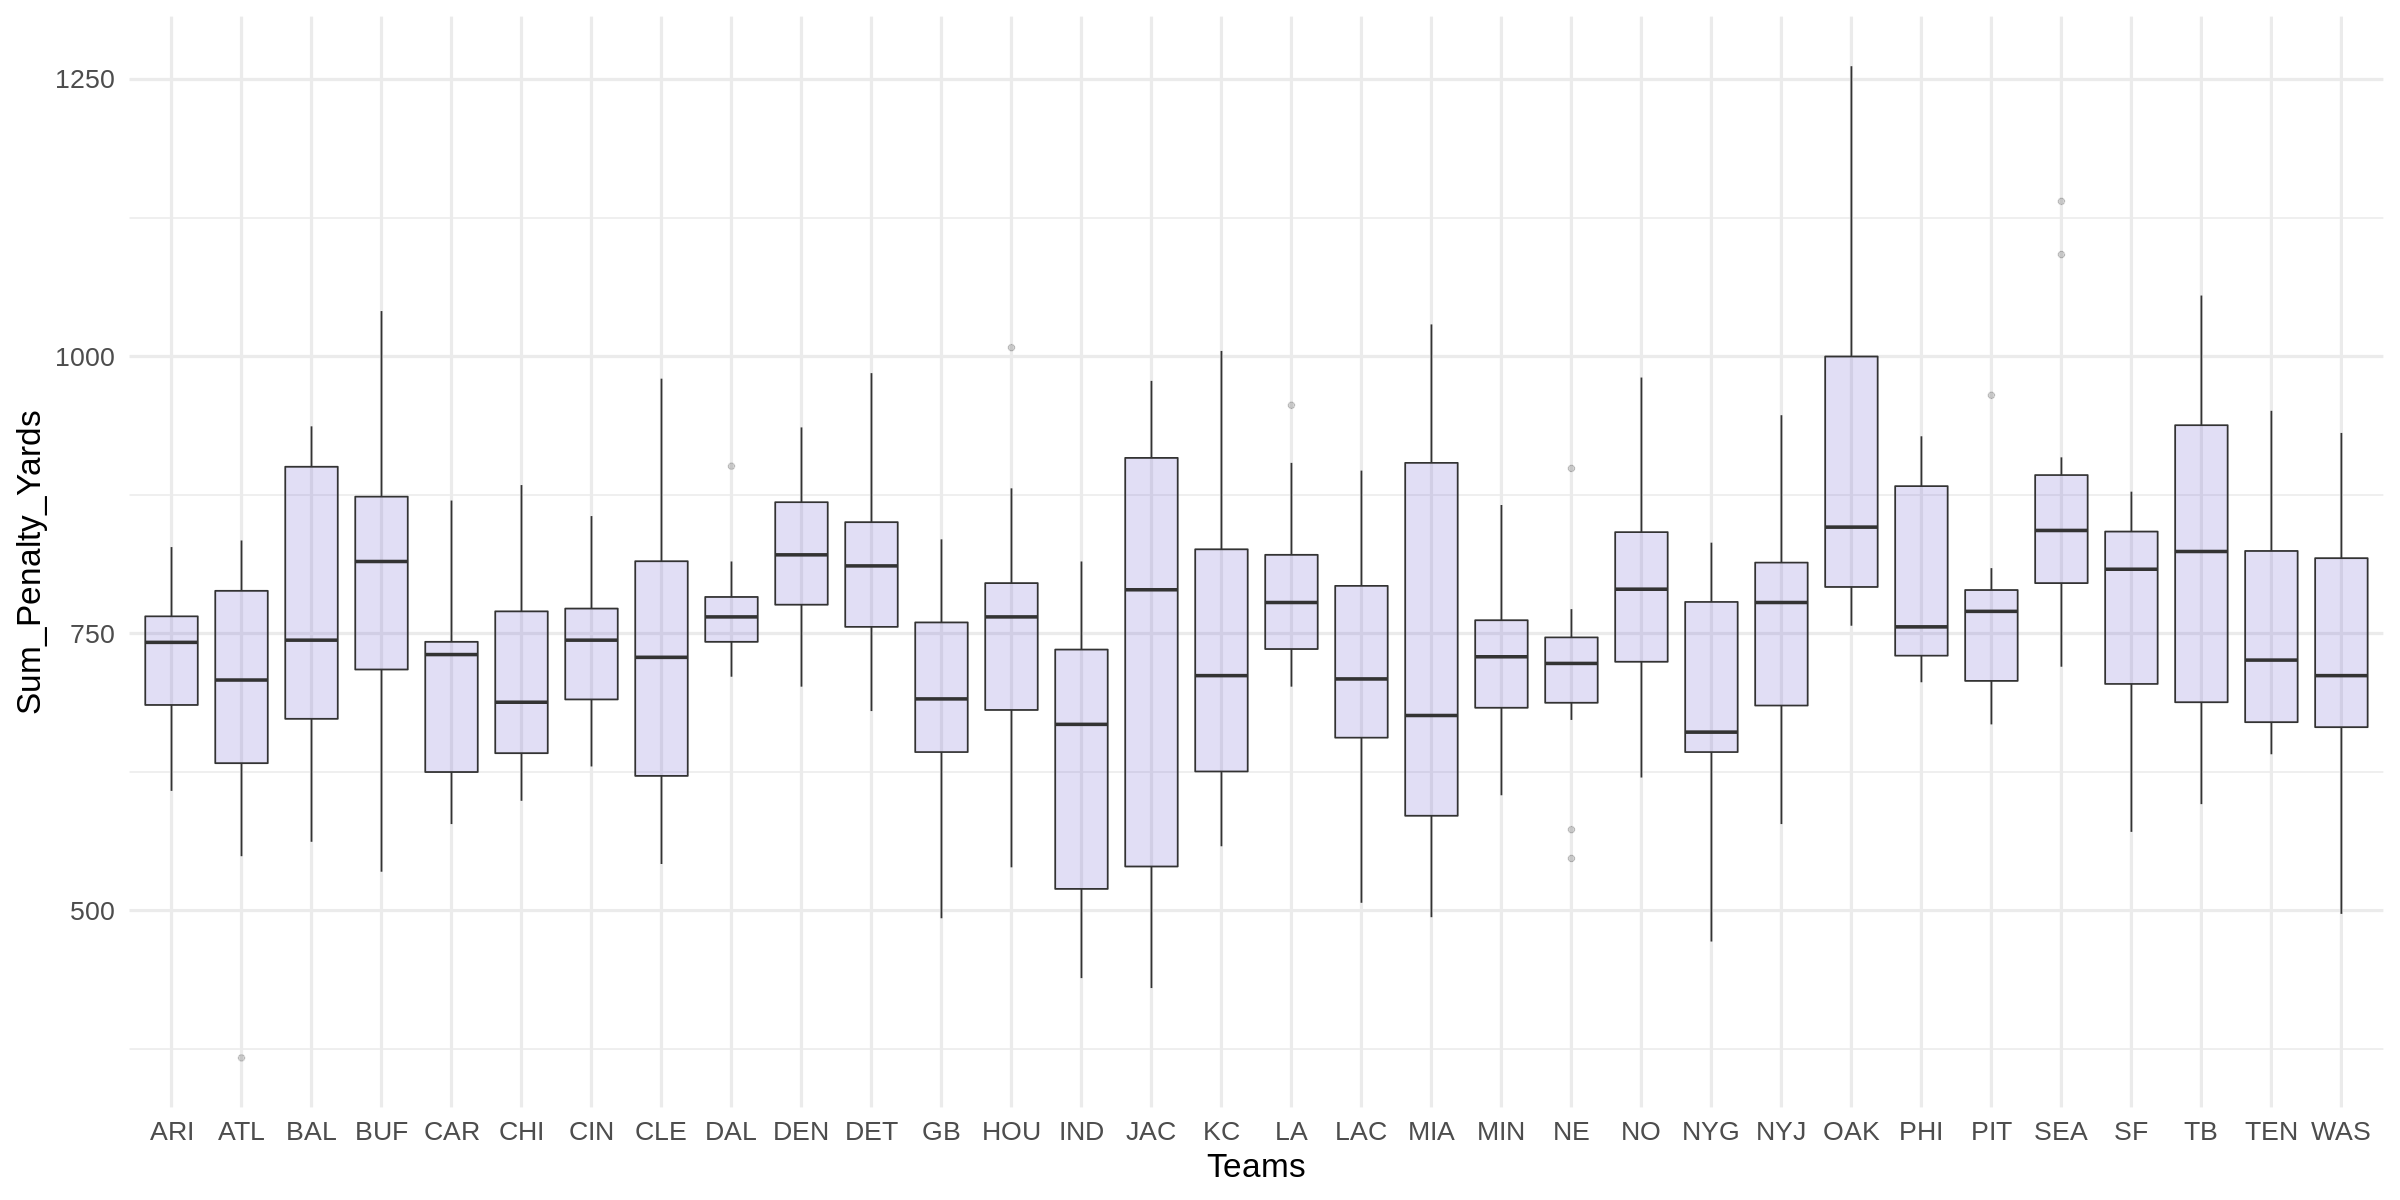

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)

ggplot(penalty_teams_yards, aes(x=(penalty_team), y=Sum_Penalty_Yards)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Teams") +
    theme_minimal(base_size = 20)

- Filter for 2019 season, cumulative count of flags for the home team and the corresponding win probability
- hoping for some correlation (more flags should theoretically lead to lower wp)

In [ ]:
pbp_all_rp %>%
group_by(game_id, penalty_team) %>%
filter(season == 2019, penalty==1, home_team==penalty_team) %>%
select(home_team, home_wp, penalty_team) %>%
mutate(penalty_count = row_number()) -> correlation_team
correlation_team


Adding missing grouping variables: `game_id`



game_id,home_team,home_wp,penalty_team,penalty_count
<dbl>,<chr>,<dbl>,<chr>,<int>
2019090500,CHI,0.3796926,CHI,1
2019090500,CHI,0.3785089,CHI,2
2019090500,CHI,0.4329962,CHI,3
2019090500,CHI,0.4485202,CHI,4
2019090500,CHI,0.4483121,CHI,5
2019090500,CHI,0.4130917,CHI,6
2019090500,CHI,0.3769627,CHI,7
2019090500,CHI,0.2120613,CHI,8
2019090800,CAR,0.5556706,CAR,1


Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”


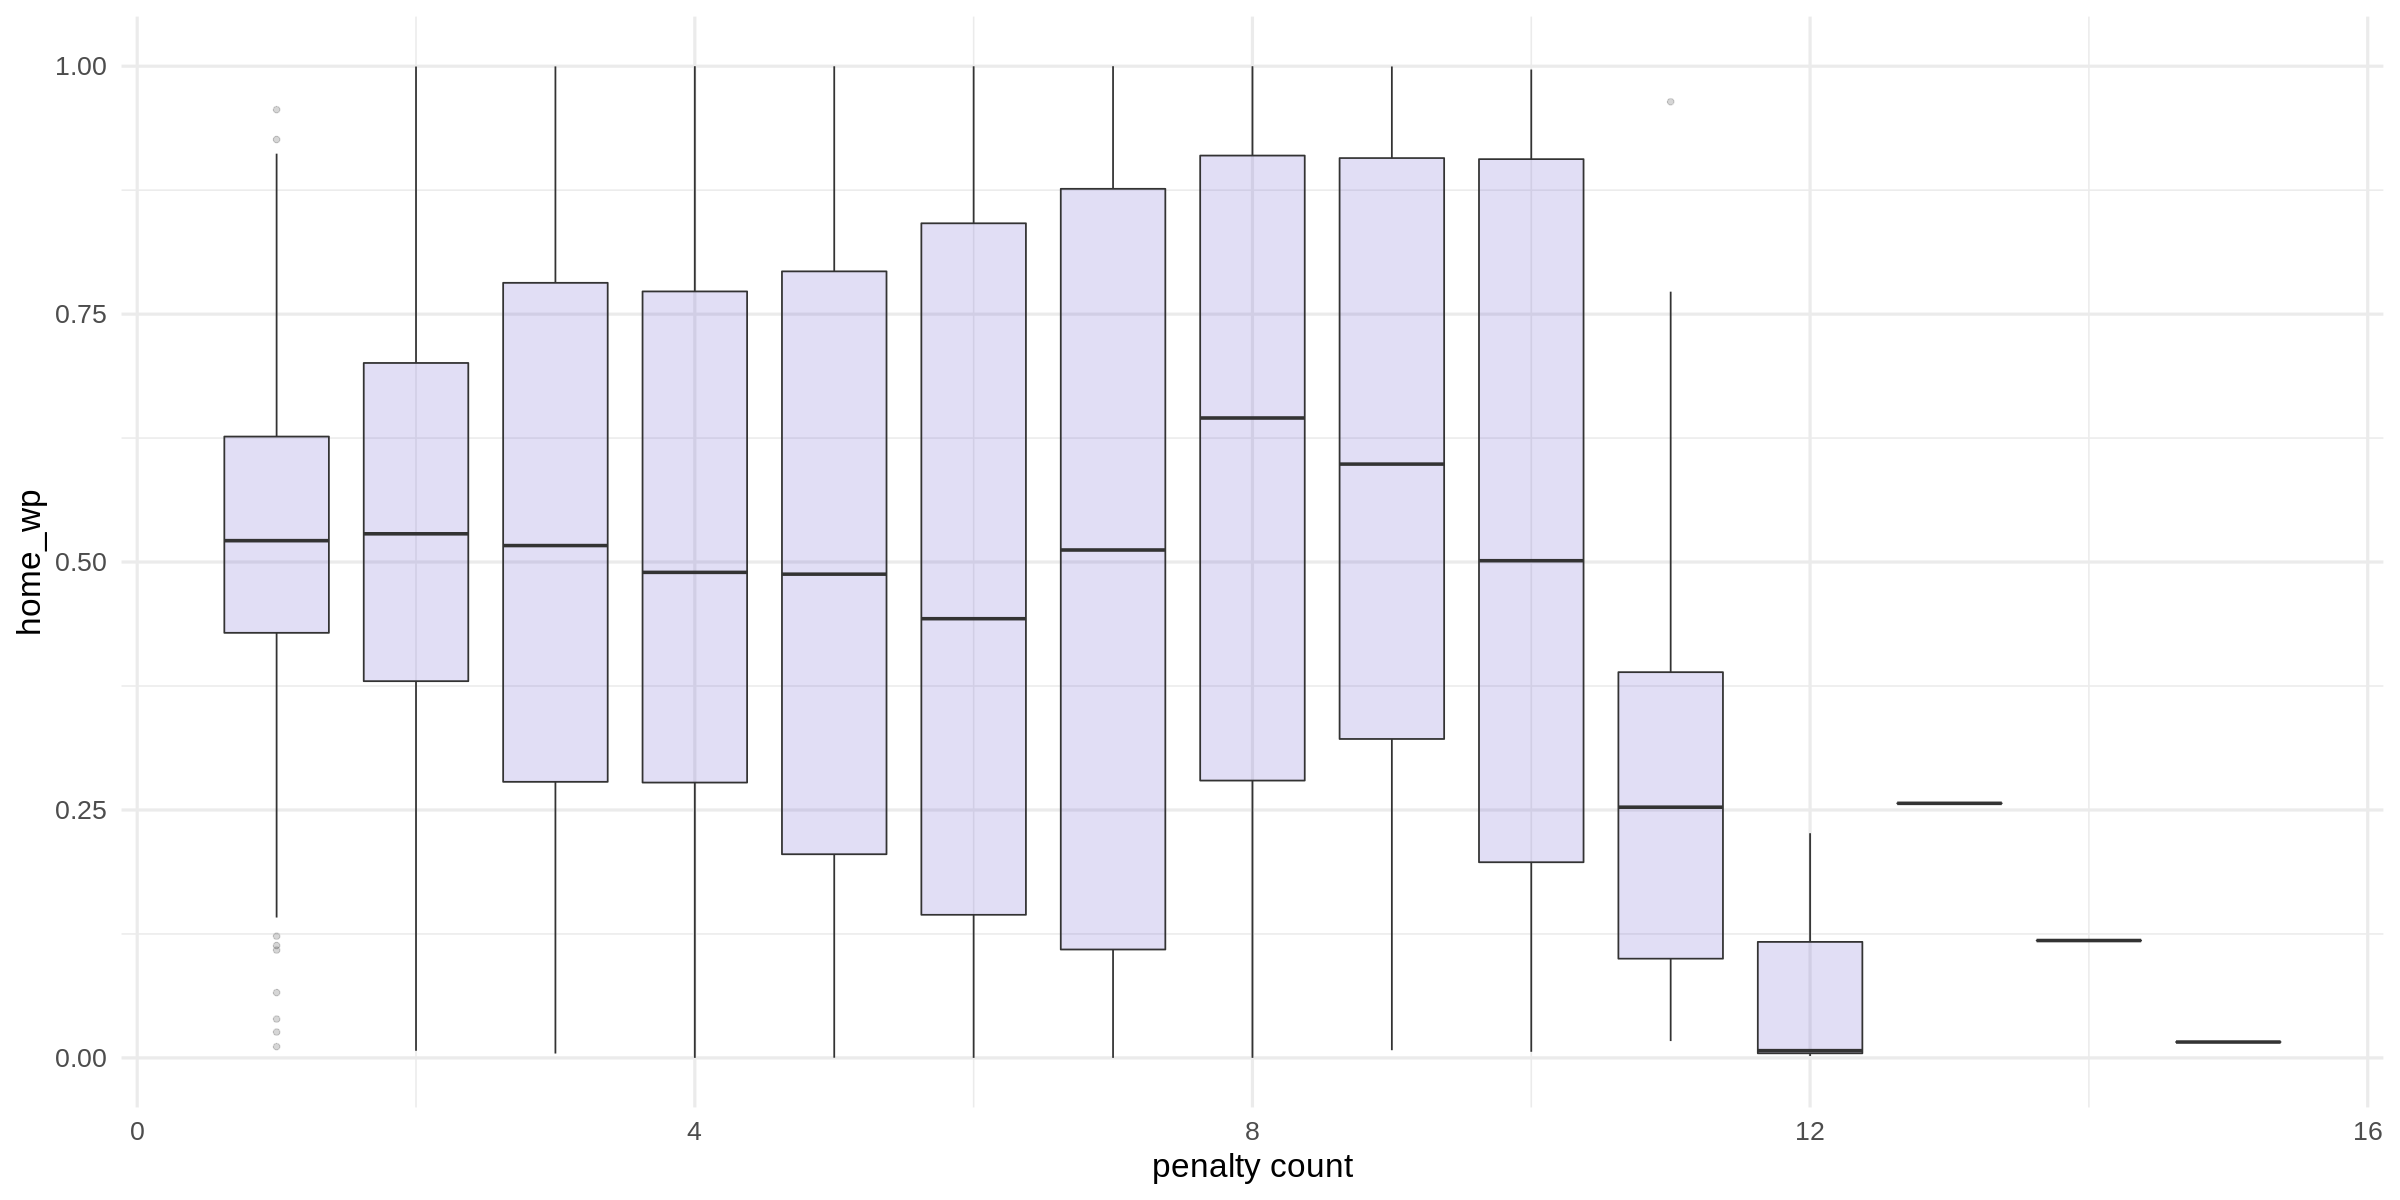

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)

ggplot(correlation_team, aes(x=penalty_count, y=home_wp)) + 
    geom_boxplot(aes(group=penalty_count), fill="slateblue", alpha=0.2) + 
    xlab("penalty count") +
    theme_minimal(base_size = 20)

* Do it for all games we have

In [21]:
pbp_all_rp %>%
group_by(game_id, penalty_team) %>%
filter(penalty==1, home_team==penalty_team) %>%
select(home_team, home_wp, penalty_team) %>%
mutate(penalty_count = row_number()) -> correlation_all
correlation_all

Adding missing grouping variables: `game_id`



game_id,home_team,home_wp,penalty_team,penalty_count
<dbl>,<chr>,<dbl>,<chr>,<int>
2009091000,PIT,0.521072515,PIT,1
2009091000,PIT,0.534517749,PIT,2
2009091000,PIT,0.498324130,PIT,3
2009091000,PIT,0.445656504,PIT,4
2009091000,PIT,0.539794912,PIT,5
2009091000,PIT,0.459829246,PIT,6
2009091304,CLE,0.587935329,CLE,1
2009091304,CLE,0.424560550,CLE,2
2009091304,CLE,0.435725178,CLE,3


* see if we need to remove outliers


In [51]:
correlation_all %>%
group_by(penalty_count) %>%
count(penalty_count)

penalty_count,n
<int>,<int>
1,2797
2,2722
3,2523
4,2188
5,1749
6,1284
7,876
8,563
9,342


* guess we can filter out < 15

Warning message:
“Removed 54 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 54 rows containing non-finite values (stat_summary).”


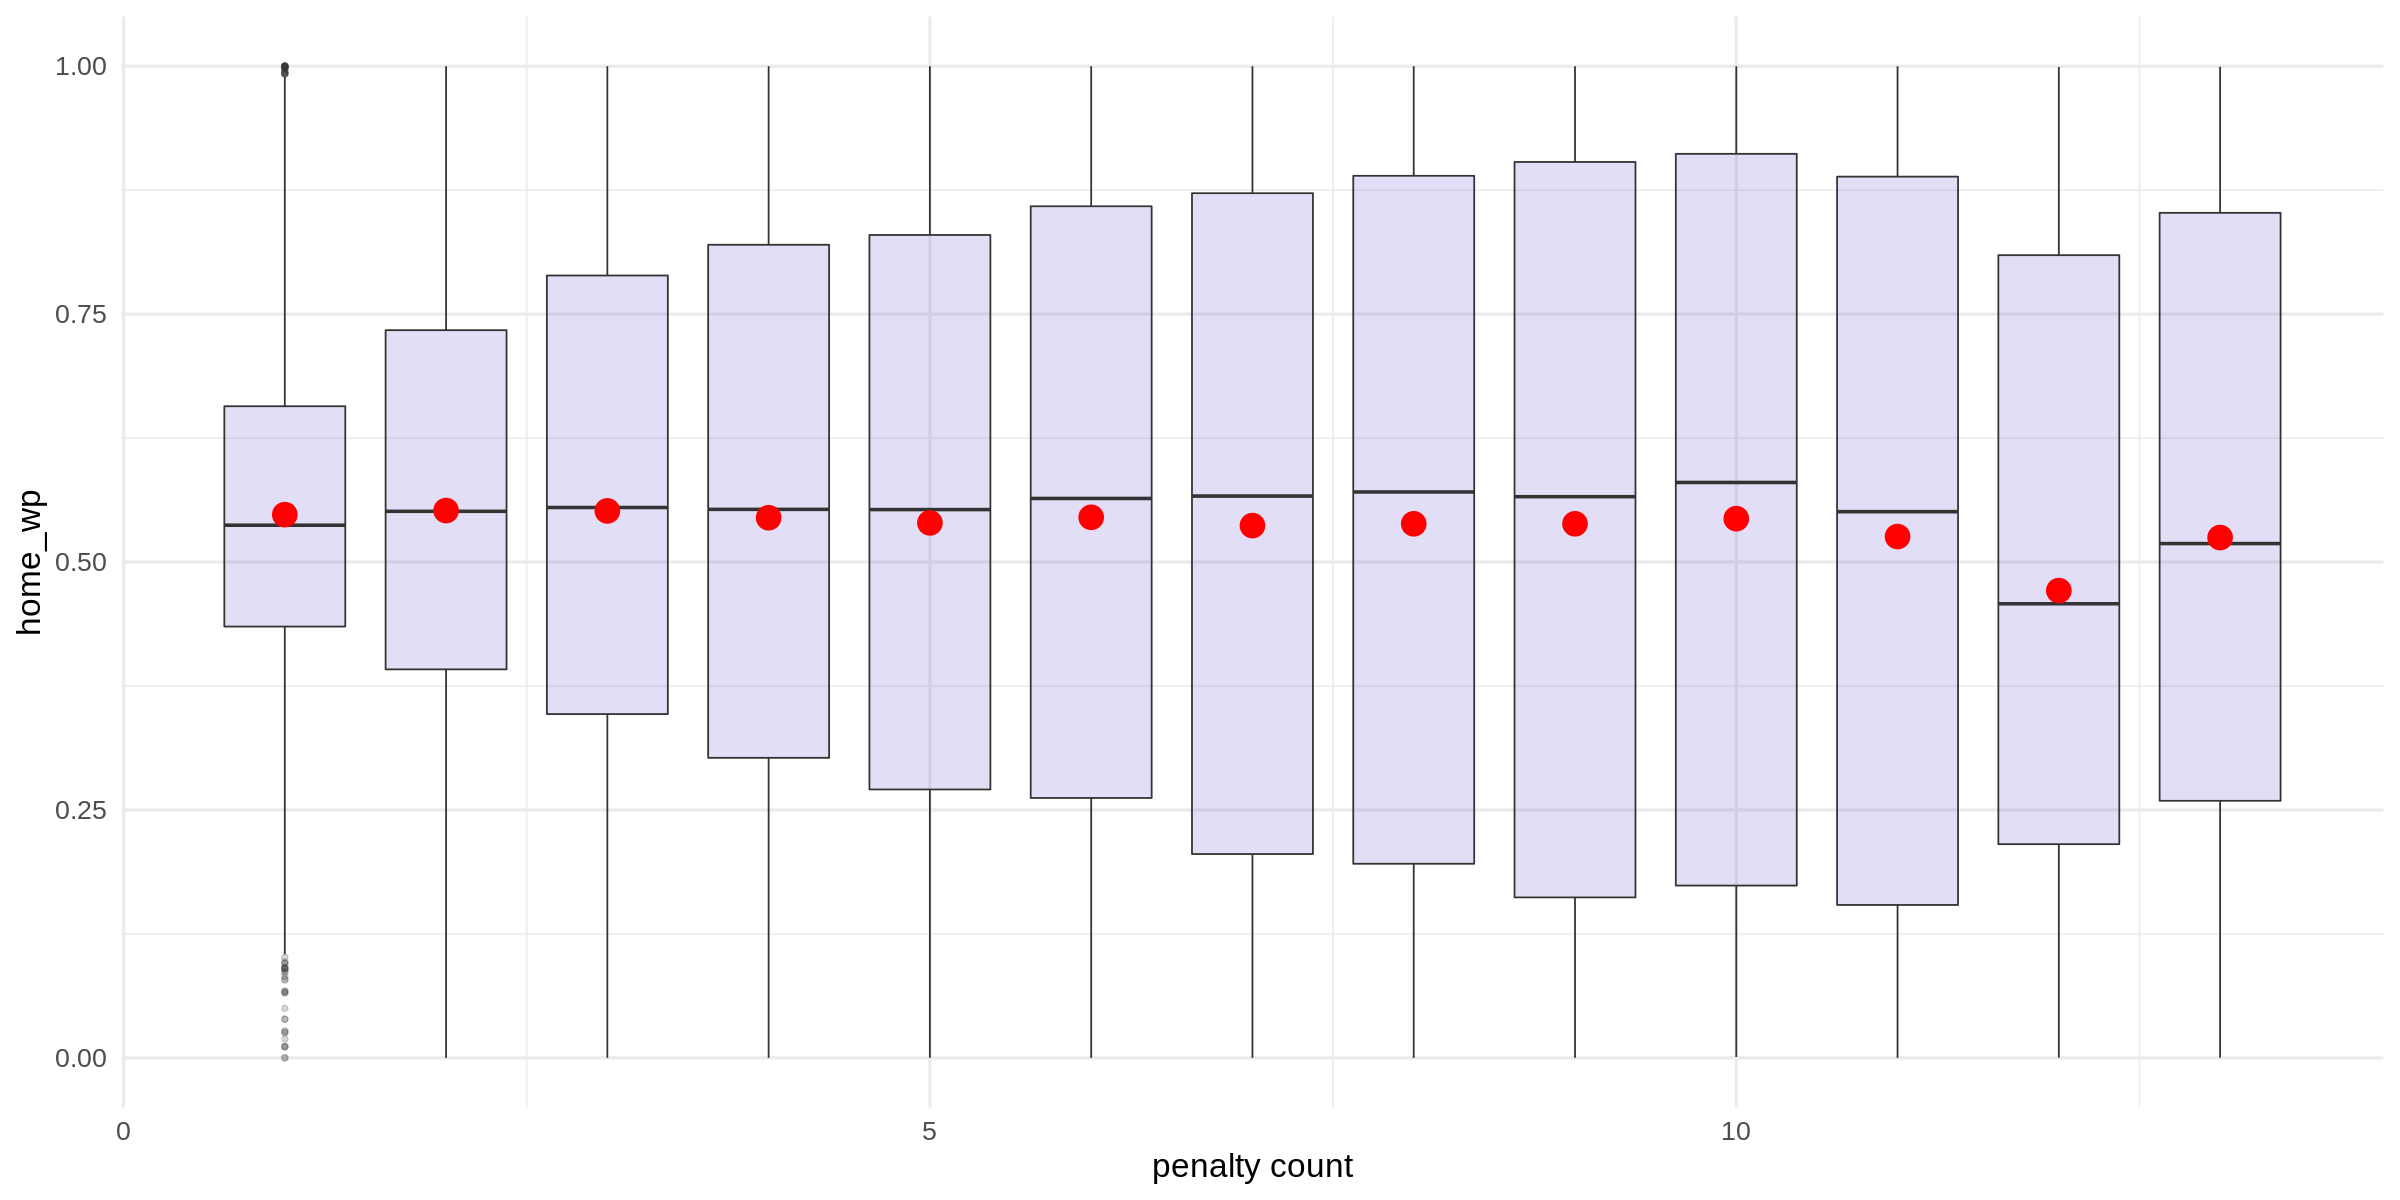

In [58]:
options(repr.plot.width=20, repr.plot.height=10)

correlation_all %>%
  filter(penalty_count < 14) %>%
  ggplot(aes(x=penalty_count, y=home_wp)) + 
    geom_boxplot(aes(group=penalty_count), fill="slateblue", alpha=0.2) + 
    stat_summary(fun=mean, geom= "point", shape = 20, size=10, color="red", fill="red") +
    xlab("penalty count") +
    theme_minimal(base_size = 20)

In [23]:
install.packages("ggridges")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




In [24]:
library(ggridges)

Warning message:
“Removed 54 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 54 rows containing non-finite values (stat_summary).”


NULL

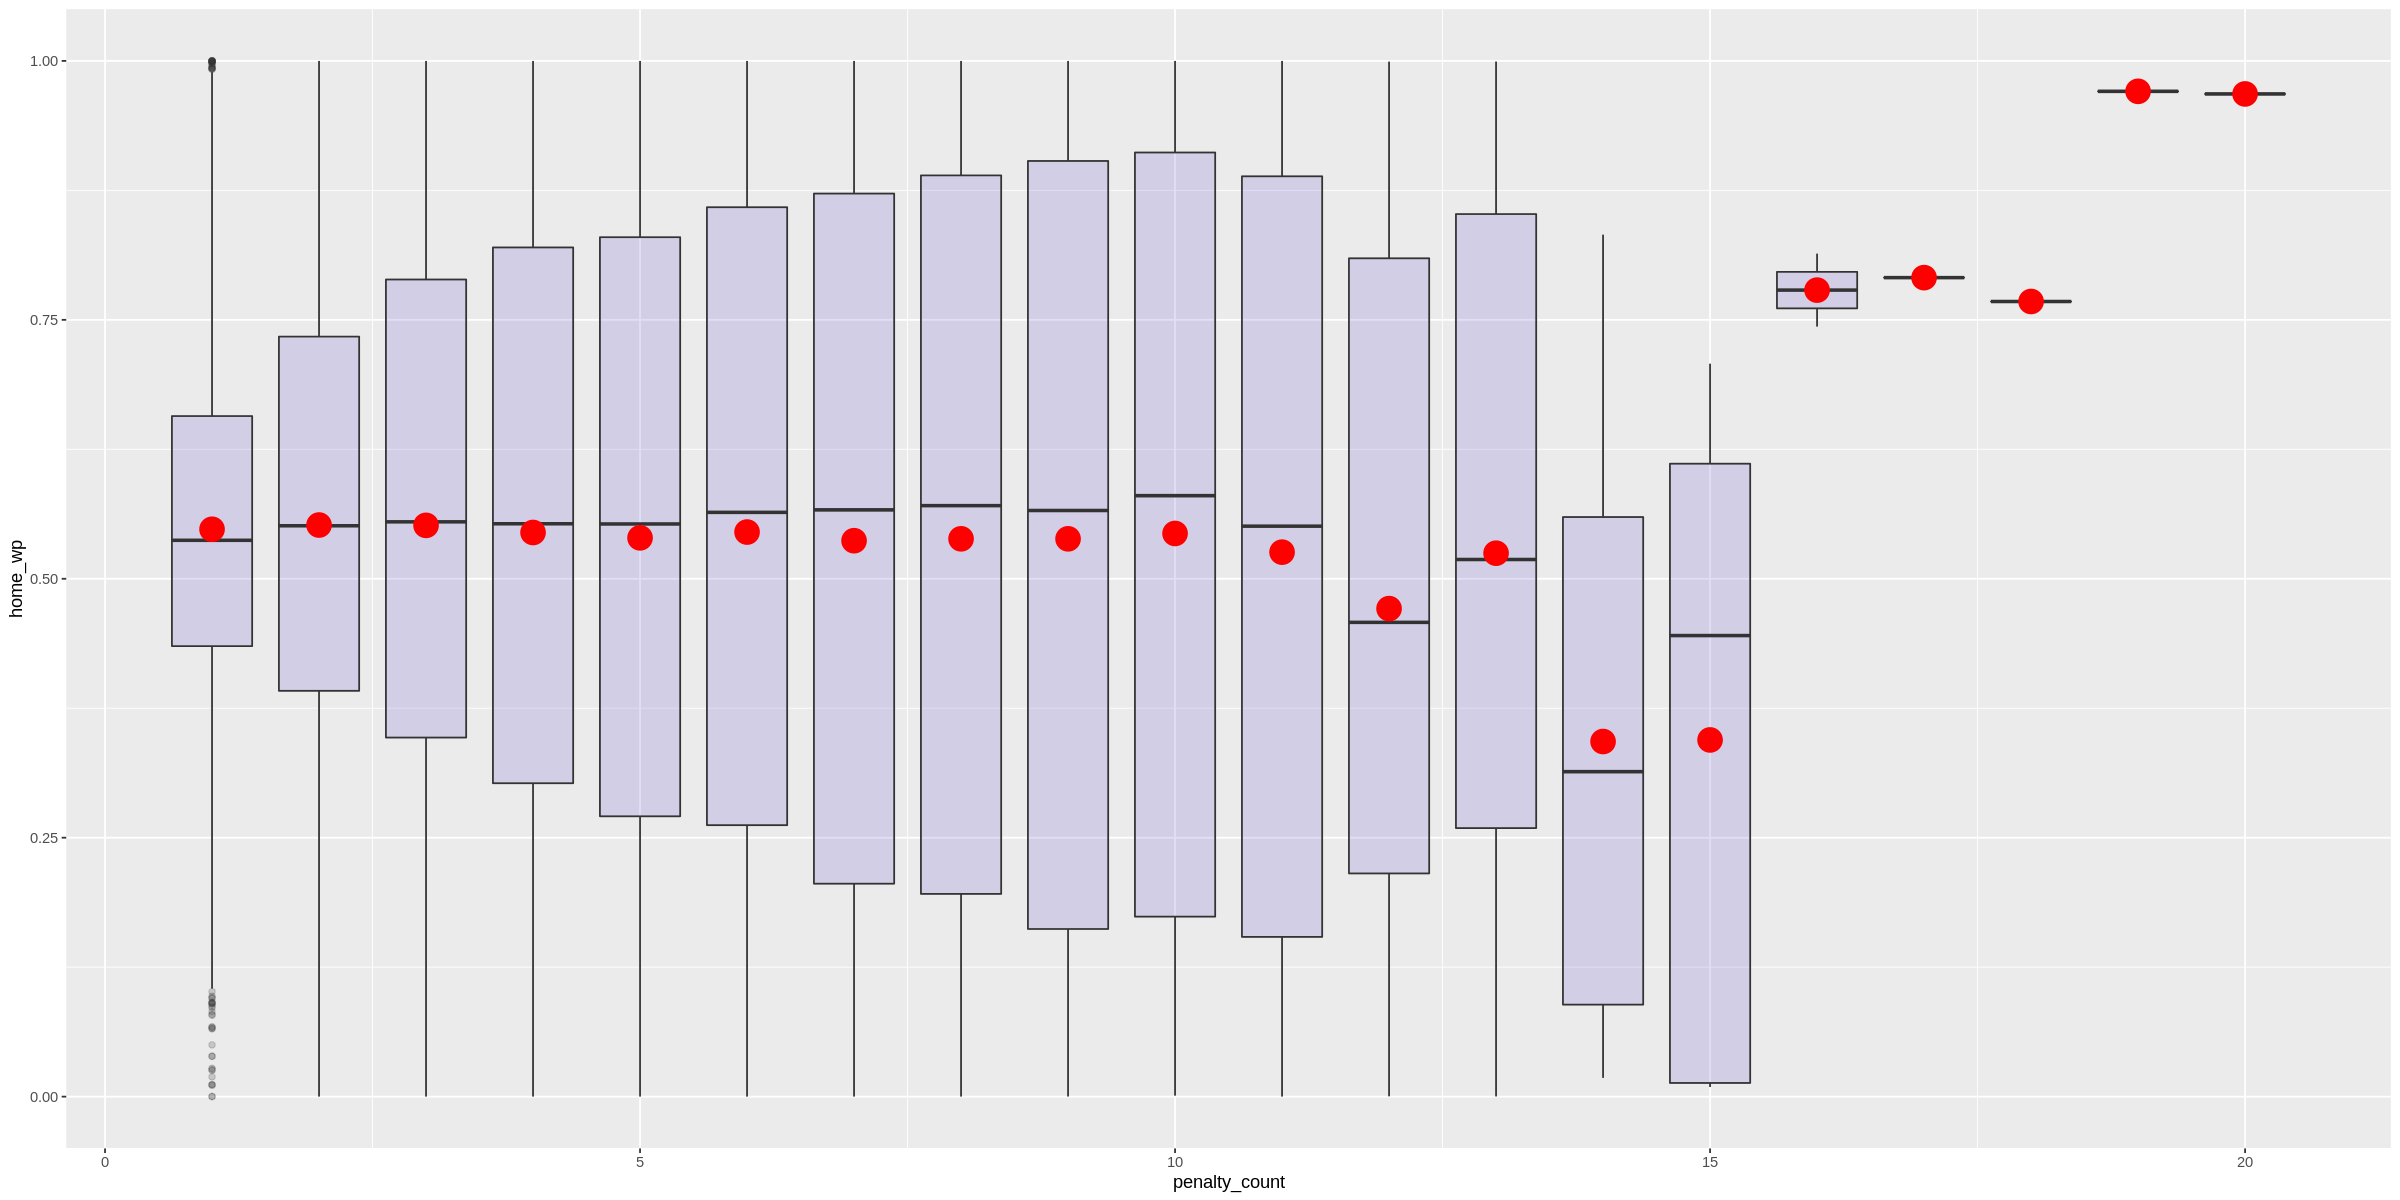

In [41]:
options(repr.plot.width=20, repr.plot.height=10)

ggplot(correlation_all, aes(x=penalty_count, y=home_wp)) + 
    geom_boxplot(aes(group=penalty_count), fill="slateblue", alpha=0.2) + 
    stat_summary(fun=mean, geom= "point", shape = 20, size=10, color="red", fill="red") +
    xlab("penalty count") +
    theme_minimal(base_size = 20)

In [50]:
correlation_all %>%
group_by(penalty_count) %>%
count(penalty_count)

penalty_count,n
<int>,<int>
1,2797
2,2722
3,2523
4,2188
5,1749
6,1284
7,876
8,563
9,342


- DO the same for Away Teams


In [ ]:
pbp_all_rp %>%
group_by(game_id, penalty_team) %>%
filter(penalty==1, away_team==penalty_team) %>%
select(away_team, away_wp, penalty_team) %>%
mutate(penalty_count = row_number()) -> correlation_team_away
correlation_team_away

Adding missing grouping variables: `game_id`



game_id,away_team,away_wp,penalty_team,penalty_count
<dbl>,<chr>,<dbl>,<chr>,<int>
2009091000,TEN,0.55100161,TEN,1
2009091000,TEN,0.49037651,TEN,2
2009091000,TEN,0.51678854,TEN,3
2009091000,TEN,0.59859761,TEN,4
2009091304,MIN,0.59895474,MIN,1
2009091304,MIN,0.55012922,MIN,2
2009091304,MIN,0.87889909,MIN,3
2009091307,DET,0.32784062,DET,1
2009091307,DET,0.18204945,DET,2


Warning message:
“Removed 67 rows containing non-finite values (stat_boxplot).”


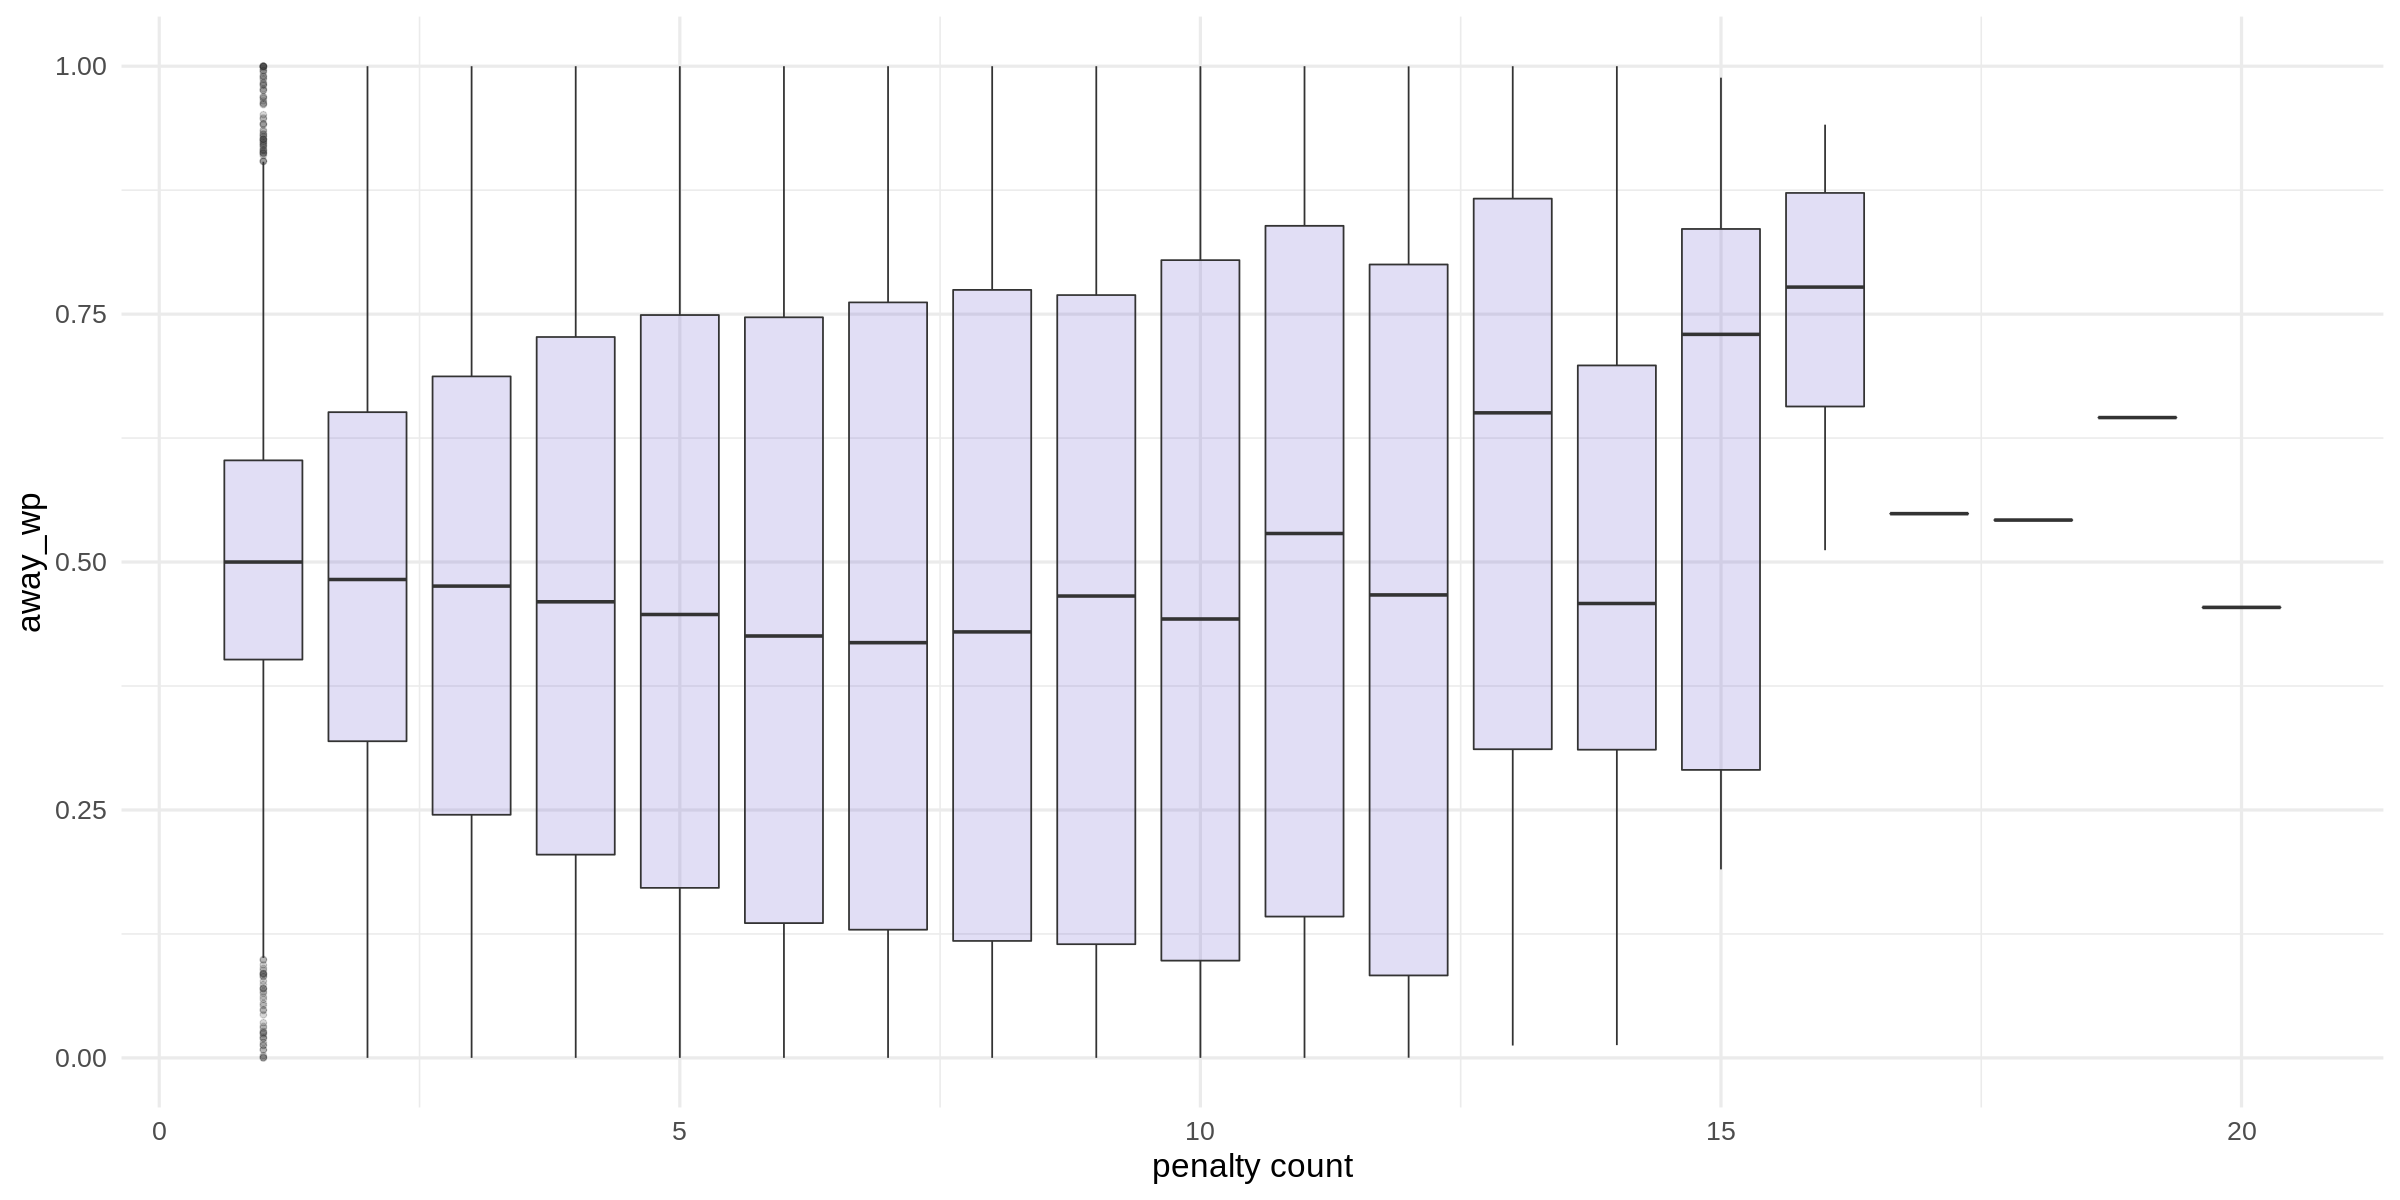

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)

ggplot(correlation_team_away, aes(x=penalty_count, y=away_wp)) + 
    geom_boxplot(aes(group=penalty_count), fill="slateblue", alpha=0.2) + 
    xlab("penalty count") +
    theme_minimal(base_size = 20)

In [ ]:
## This could be useful in the future for passer analysis


QB.Rating <- nfl %>%
  filter(PlayType=="Pass") %>%
  mutate(QB.team = paste(Passer,posteam,sep=" ")) %>%
  group_by(QB.team, posteam, posteamcolor) %>%
  summarise(Games.Played = n_distinct(Date),
                Total.Passes = n(),
                Completed = length(PassOutcome[PassOutcome=="Complete"]),
                Incomplete = length(PassOutcome[PassOutcome=="Incomplete Pass"]),
                Completion.Rate = round(Completed/Total.Passes,3)*100,
                Total.Yards = sum(Yards.Gained),
                Yards.per.Att = sum(Yards.Gained)/Total.Passes,
                Interceptions = sum(InterceptionThrown),
                Interceptions.per.att = round(Interceptions/Total.Passes,3)*100,
                TDs = sum(Touchdown),
                TDs.per.att = round(TDs/Total.Passes,3)*100,
                TDs.per.INT = round(TDs/Interceptions,3)*100) %>%
  filter(QB.team %in% starters.team) %>%
  arrange(posteam,-Completion.Rate, -Total.Passes)

Do the flag correlation to win probability but with penalty yards

In [11]:
pbp_all_rp %>%
group_by(game_id, penalty_team) %>%
filter(penalty==1, home_team==penalty_team) %>%
select(home_team, home_wp, penalty_team, penalty_yards) %>%
mutate(SUM_YARDS = cumsum(penalty_yards)) -> penalty_yards_correlation
penalty_yards_correlation



Adding missing grouping variables: `game_id`



game_id,home_team,home_wp,penalty_team,penalty_yards,SUM_YARDS
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
2009091000,PIT,0.521072515,PIT,15,15
2009091000,PIT,0.534517749,PIT,10,25
2009091000,PIT,0.498324130,PIT,10,35
2009091000,PIT,0.445656504,PIT,15,50
2009091000,PIT,0.539794912,PIT,5,55
2009091000,PIT,0.459829246,PIT,5,60
2009091304,CLE,0.587935329,CLE,10,10
2009091304,CLE,0.424560550,CLE,5,15
2009091304,CLE,0.435725178,CLE,16,31


In [18]:
penalty_yards_correlation %>%
group_by(SUM_YARDS) %>%
summarize(Mean_WP = mean(home_wp, na.rm=TRUE)) -> co_plot
co_plot

`summarise()` ungrouping output (override with `.groups` argument)



SUM_YARDS,Mean_WP
<dbl>,<dbl>
0,0.4905532
1,0.4628771
2,0.3858134
3,0.4450950
4,0.4953053
5,0.5489755
6,0.5539428
7,0.5012092
8,0.4583087


Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


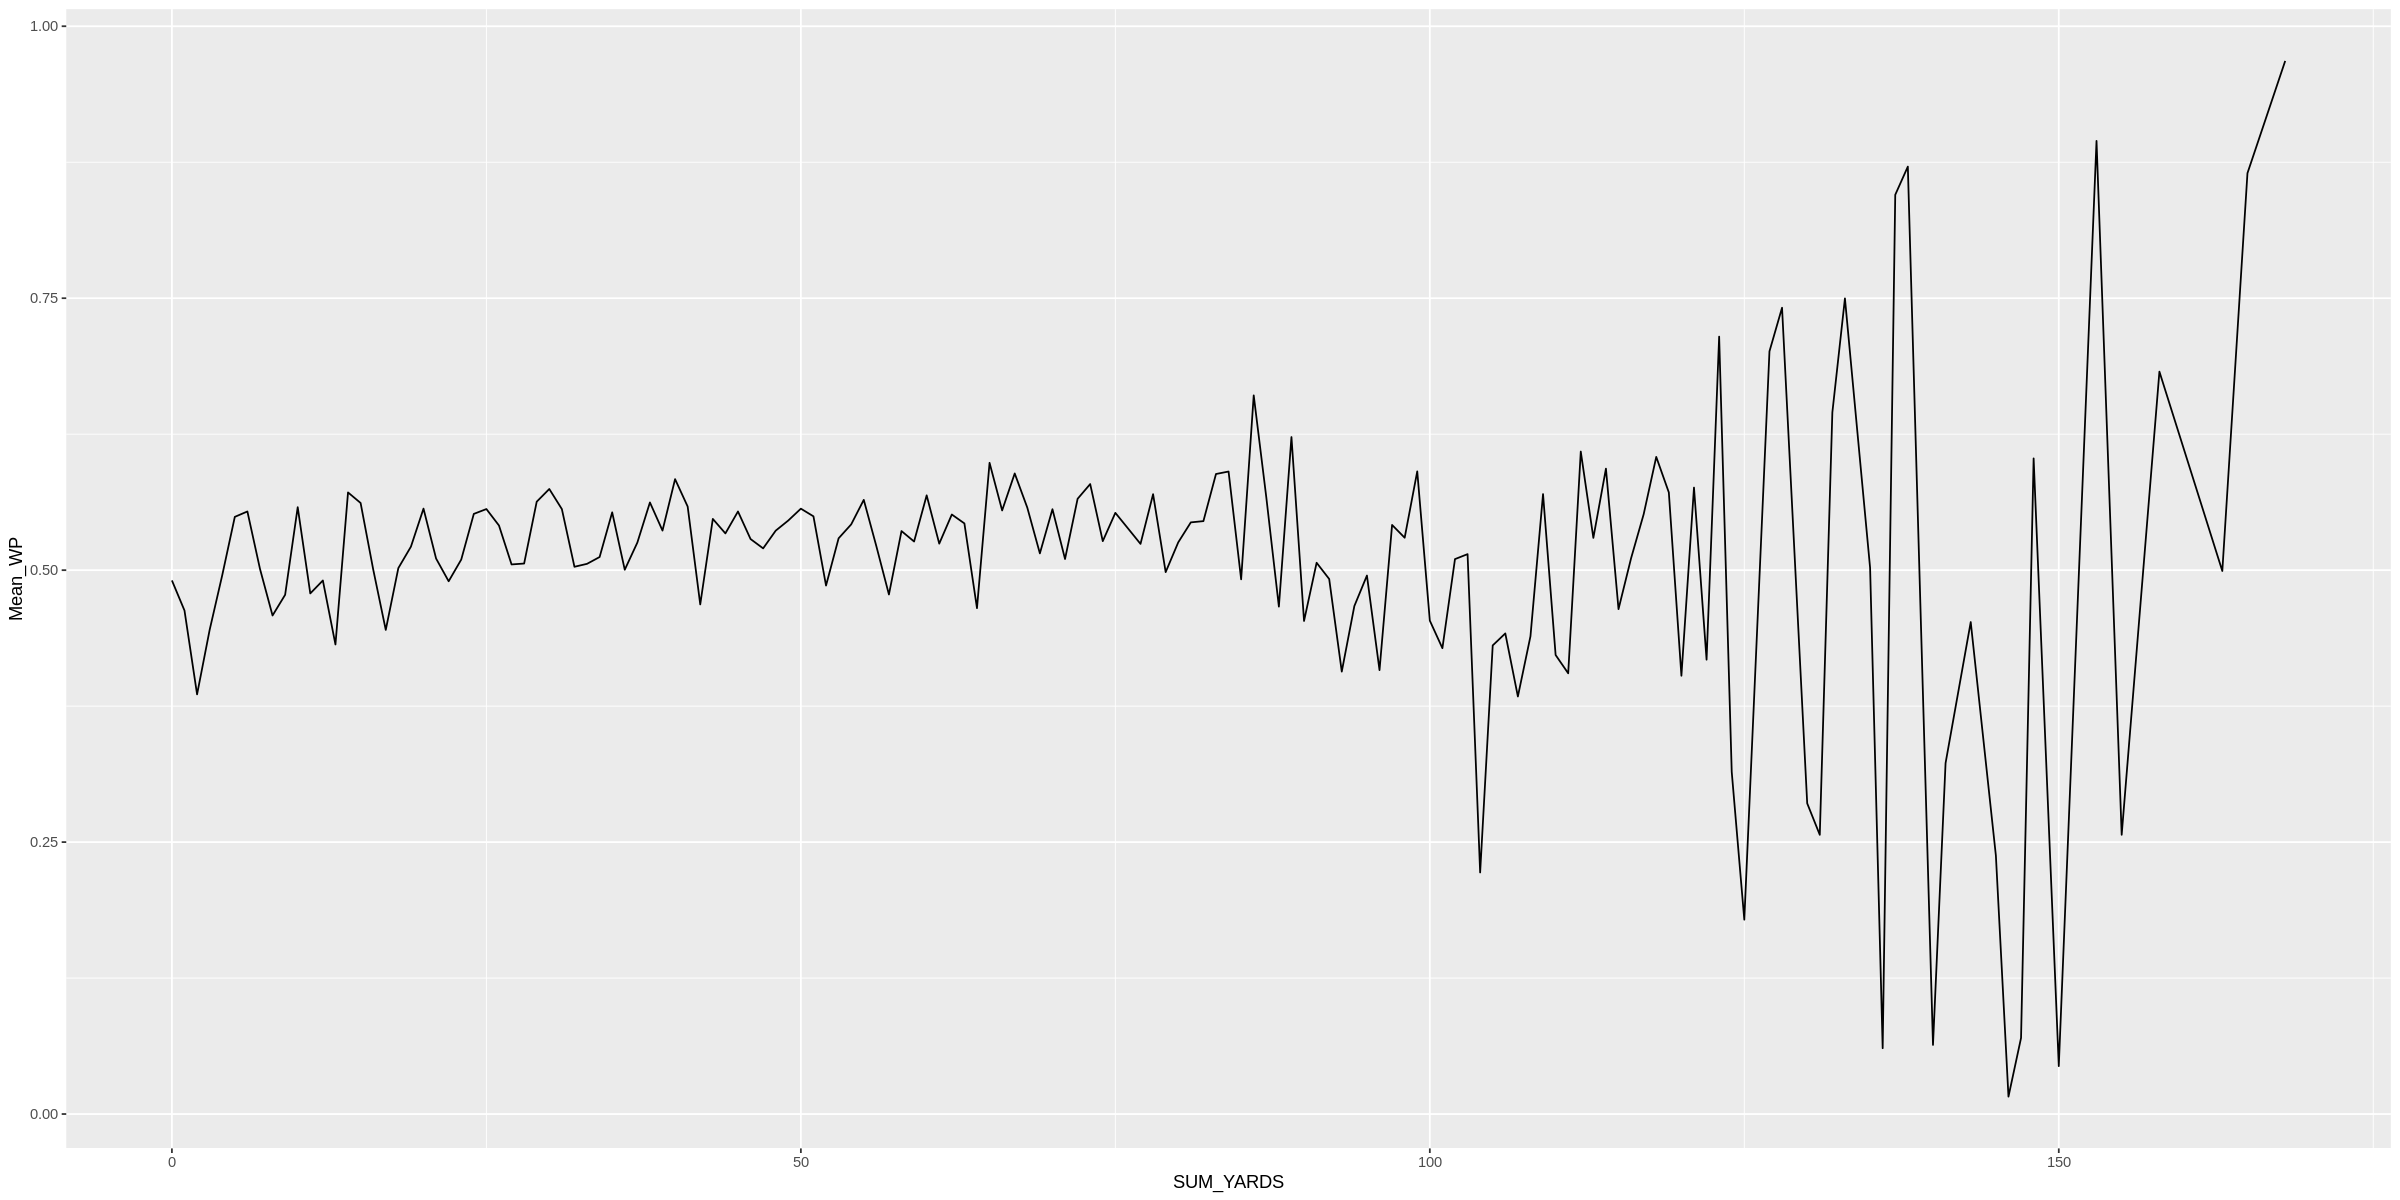

In [20]:
ggplot(co_plot, aes(x= SUM_YARDS, y=Mean_WP)) +
geom_line()